In [1]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision import datasets
from torch import nn
import wandb
from PIL import Image
import random
import pandas as pd
import numpy as np
import os
import torchaudio
import tqdm
import librosa
from torchaudio import transforms
from torch.utils.data import DataLoader, Dataset,TensorDataset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, accuracy_score
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import f1_score

/home/gustavo/anaconda3/envs/rnp/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch import nn
import random

In [3]:
# Get cpu, gpu or mps device for training.
DEVICE = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {DEVICE} device")

NUM_WORKERS = 4

Using cuda device


In [25]:
class game_model():
    def __init__(self, n, pieces):
        self.n = n
        self.pieces = pieces
        self.matriz = np.full((n,n),0,dtype=int)
        self.reward_matriz = np.full((n,n), 0.5)
    
    def reset_matrix(self):
        self.matriz = np.full((self.n,self.n),0,dtype=int)
        self.reward_matriz = np.full((self.n,self.n), 0.5)


    def print_matrix(self):
        for i in range(0,self.n):
            print(self.matriz[i][:], ' --- ', self.reward_matriz[i][:])


    def print_reward(self):
        for i in range(0,self.n):
            print(self.reward_matriz[i][:])


    def print_game(self):
        matriz = self.matriz
        substituicoes = {5: "X", 7: "O", 0:' '}
        for linha in matriz:
            linha_formatada = [str(substituicoes.get(valor, valor)) for valor in linha]
            print(" | ".join(linha_formatada))
            print("-" * 9)


    def get_reward_number(self):
        return np.argmax(self.reward_matriz)
    

    def calc_reward_matrix(self,piece):
        reward_matriz = np.zeros(shape=(self.n,self.n))

        for i in range(0,self.n):
            alpha  = 0.4
            beta = 0.4
            omega = 0.2

            values_row,counts_row = np.unique(self.matriz[i,:], return_counts=True)
            index_piece = np.where(values_row==piece)
            index_other = np.where((values_row!=piece) & (values_row!=0))
            index_0 = np.where(values_row==0)

            values_col,counts_col = np.unique(self.matriz[:,i], return_counts=True)
            index_piece_col = np.where(values_col==piece)
            index_other_col = np.where((values_col!=piece) & (values_col!=0))
            index_0_col = np.where(values_col==0)


            rows = np.sum(counts_row[index_piece])*alpha+(-np.sum(counts_row[index_other])*omega)**2 + index_0[0].shape[0]*beta
            cols = np.sum(counts_col[index_piece_col])*alpha+(-np.sum(counts_col[index_other_col])*omega)**2 + index_0_col[0].shape[0]*beta
            reward = rows+cols
            reward_matriz[i,np.where(self.matriz[i,:]==0)] = reward
        
        self.reward_matriz = reward_matriz


    def number_ij(self, number):
        i = number//self.n
        j = number % self.n
        return i,j
    

    def ji_number(self, i, j):
        number = i * self.n + j
        return number
    

    def get_random_move(self):
        possible_move_i, possible_move_j = np.where(self.matriz == 0)
        
        if possible_move_j.shape[0] > 0:  # Verifica se há movimentos possíveis
            index = random.randint(0, possible_move_j.shape[0] - 1)  # Correção aqui
        else:
           pass
        return possible_move_i[index], possible_move_j[index]


    def move(self,index_i,index_j,piece):
        if self.matriz[index_i][index_j] == 0:
            self.matriz[index_i][index_j] = piece
        else:
            #print("Jogada invalida")
            pass
        
          
    def check_win(self):
        state = False
        win_piece = -1
        value_counts_diagonal = np.unique(self.matriz.diagonal())
        value_counts_diagonal2  = np.unique(np.fliplr(self.matriz).diagonal())
        if value_counts_diagonal.shape[0] == 1 and value_counts_diagonal[0] !=0:
            state=True     
            win_piece = value_counts_diagonal[0] 
            return win_piece          
        if value_counts_diagonal2.shape[0] == 1 and value_counts_diagonal2[0] !=0:
            state=True    
            win_piece = value_counts_diagonal2[0]   
            return win_piece         

        for i in range(0,self.n):
            value_counts_linha = np.unique(self.matriz[i,:])
            value_counts_coluna = np.unique(self.matriz[:,i])
            
            if value_counts_linha.shape[0] == 1 and value_counts_linha[0] != 0 :
                state=True
                win_piece = value_counts_linha[0]
                break
            if value_counts_coluna.shape[0] == 1 and value_counts_coluna[0] != 0:
                state=True
                win_piece = value_counts_coluna[0]
                break
            
        velha = np.where(self.matriz == 0)
        
        if state:
            return win_piece
        if velha[0].shape[0] == 0: 
            return 1      



In [12]:
class Evaluator:
    '''
    [EN] Evaluator class for loss function
    [PT-BR] Classe de Evaluator do modelo para função de custo
    '''
    def __init__(self):
        self.loss_fn = nn.MSELoss()

    def get_loss(self, y, y_hat):
        return self.loss_fn(y_hat, y)
    

# Define model
class NeuralNetwork(nn.Module):
    
    def __init__(self):
        super().__init__() 
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(9, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32,24),
            nn.ReLU(),
            nn.Linear(24,24),
            nn.ReLU(),
            nn.Linear(24, 16),
            nn.ReLU(),
            nn.Linear(16, 9)
        )

    def forward(self, x):

        x = self.linear_relu_stack(x)
        return x

   
    
class Learner:
    '''
    [EN]Defining the optimizer of model, Adam is used for faster convergence
    [PT-BR]Definindo um otimizadar para o modelo, o Adam é usado para ter uma convergência mais rápida
    '''
    def __init__(self):
        self.model = NeuralNetwork()
        self.model.to(DEVICE)
        self.optimizer = torch.optim.SGD(self.model.parameters(), lr=1e-3)

    def predict(self, x):
        return self.model(x)

    def update(self, loss):
        # Backpropagation
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

In [30]:
class Trainer:
    def __init__(self, learner: Learner, evaluator: Evaluator, game: game_model):
        self.learner = learner
        self.evaluator = evaluator
        self.game = game
       
    
    def play_one_game(self, training):
        win_piece =-1
        states = []
        rewards_y = []
        rewards = []
        reward = 0
        while True:
            # Obter estado do jogo
            print("==========================================")
            self.game.print_game()
            X = torch.from_numpy(self.game.matriz).flatten().view(-1).to(torch.float32)
            states.append(X)
            X = X.to(DEVICE)

            # Fazer a previsão da jogada
            y_hat = self.learner.predict(X)
            y_pred = y_hat.argmax(0).item()
            w = self.game.check_win()
            if w == 5 or w == 7 or w == 0:
                win_piece = w
                self.game.reset_matrix()
                break

            i, j = self.game.number_ij(y_pred)
            self.game.move(i, j, 5)
            print("==========================================")
            self.game.print_game()

            if w == 5 or w == 7 or w == 0:
                win_piece = w
                self.game.reset_matrix()
                break

            i, j = self.game.get_random_move()
            self.game.move(i, j, 7)
            print("==========================================")



        if win_piece == 5:
            reward = 1
        elif win_piece == 7:
            reward =-1
        else:
            reward = 0.1
        

        for i in range(0,len(states)):
            rw = float(reward)
            r = 1.0

            rewards.append(r)
            rewards_y.append(rw)
        
        states_np = np.array(states)
        y_np = np.array(rewards)
        y_hat_np = np.array(rewards_y)
        self.learner.model.train(training)
        
        X = torch.from_numpy(states_np).to(DEVICE)
        y_hat = torch.from_numpy(y_hat_np).to(DEVICE).requires_grad_(True)
        y = torch.from_numpy(y_np).to(DEVICE)
        
        loss = self.evaluator.get_loss(y,y_hat)

        self.learner.update(loss)
        loss = loss.item()

        return loss, win_piece         
                
            
    def run(self, n_epochs: int):
        #wandb.init(project="RL-tictactoe", entity="gustavoreis")
        games = []
        losses = []
        for i in tqdm.tqdm(range(0,n_epochs)):
            print('game',i)
            loss,w = self.play_one_game(True)
            games.append(w)
            losses.append(loss)
            #wandb.log({"Loss/train per game": loss})
        return losses,games

In [31]:
lean = Learner()
evalu = Evaluator()
tab  =game_model(n=3,pieces=[5,7])

tr = Trainer(learner=lean, evaluator=evalu, game=tab)
losses, games = tr.run(3)


100%|██████████| 3/3 [00:00<00:00, 310.83it/s]

game 0
  |   |  
---------
  |   |  
---------
  |   |  
---------
  |   |  
---------
X |   |  
---------
  |   |  
---------
  | O |  
---------
X |   |  
---------
  |   |  
---------
  | O |  
---------
X |   |  
---------
  |   |  
---------
  | O |  
---------
X | O |  
---------
  |   |  
---------
  | O |  
---------
X | O |  
---------
X |   |  
---------
O | O |  
---------
X | O |  
---------
X |   |  
---------
O | O |  
---------
X | O |  
---------
X |   |  
---------
O | O | O
---------
X | O |  
---------
X |   |  
---------
game 1
  |   |  
---------
  |   |  
---------
  |   |  
---------
  |   |  
---------
X |   |  
---------
  |   |  
---------
  |   |  
---------
X |   | O
---------
  |   |  
---------
  |   |  
---------
X |   | O
---------
  |   |  
---------
  |   |  
---------
X | O | O
---------
  |   |  
---------
  |   |  
---------
X | O | O
---------
  |   |  
---------
  |   |  
---------
X | O | O
---------
  |   | O
---------
  |   |  
---------
X | O 

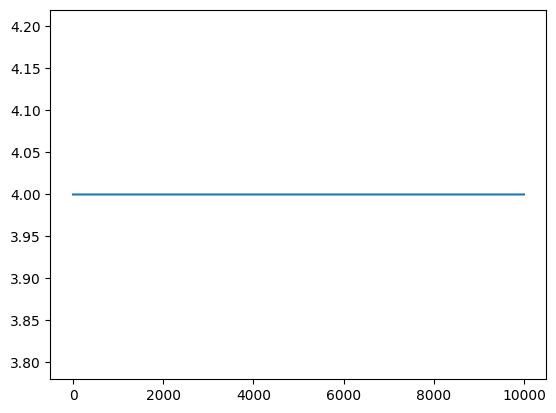

In [21]:
plt.plot(losses)

In [22]:
games = np.array(games)

print(f"Jogos ganhos: {np.where(games==5)[0].shape[0]} \n",
      f"Jogos perdidos: {np.where(games==7)[0].shape[0]} \n",
      f"Jogos empatados: {np.where(games==0)[0].shape[0]}\n")

Jogos ganhos: 0 
 Jogos perdidos: 10000 
 Jogos empatados: 0



In [10]:
tab  =game_model(n=3,pieces=[5,7])
while True:
    tab.calc_reward_matrix(piece=5)
    number = np.argmax(tab.reward_matriz)
    i,j = tab.number_ij(number)
    tab.move(i,j,5)
    if tab.check_win() == 5 or tab.check_win()== 7 or tab.check_win() ==0:
        break
    print("Jogada ia")
    tab.print_matrix()
    print('Jogada humano')
    n = int(input())
    i,j = tab.number_ij(n)
    tab.move(i,j,7)
    if tab.check_win() == 5 or tab.check_win()== 7 or tab.check_win() ==0:
        break
    tab.print_matrix()

tab.print_matrix()
print()

print(tab.check_win())



Jogada ia
[5 0 0]  ---  [0.8 0.8 0.8]
[0 0 0]  ---  [0.8 0.8 0.8]
[0 0 0]  ---  [0.8 0.8 0.8]
Jogada humano
[5 7 0]  ---  [0.8 0.8 0.8]
[0 0 0]  ---  [0.8 0.8 0.8]
[0 0 0]  ---  [0.8 0.8 0.8]
Jogada ia
[5 7 5]  ---  [0.   0.   1.64]
[0 0 0]  ---  [0.84 0.84 0.84]
[0 0 0]  ---  [0.8 0.8 0.8]
Jogada humano


ValueError: invalid literal for int() with base 10: ''